# export logic network code to verilog, to run on Lattice ICE FPGA

this system is currently limited to max 8 inputs and max 8 outputs

this notebook generates random networks and tests them using a serial connection

copy the 'exportToVerilog' function to export trained networks in other notebooks

In [932]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ck84/miniconda3/envs/conda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [933]:
import serial

In [1015]:
!ls /dev/ttyUSB*

/dev/ttyUSB2


In [935]:
deviceName = '/dev/ttyUSB1'

In [936]:
ser = serial.Serial(deviceName, 9600, bytesize=serial.EIGHTBITS, 
                    parity=serial.PARITY_NONE, stopbits=serial.STOPBITS_TWO) 
print(ser.name)
print(ser.is_open)

/dev/ttyUSB1
True


In [937]:
#test (assuming serial firmware already loaded)
ser.write(bytearray([0]))

a = ser.read()
print(a)

b'\x01'


In [938]:
#larger scale test (assuming serial firmware already loaded)
for i in arange(255):
    v = bytearray([i])
    ser.write(v)
    output = ser.read()
    print(v,output, int.from_bytes(output, "big"))

bytearray(b'\x00') b'\x01' 1
bytearray(b'\x01') b'\x00' 0
bytearray(b'\x02') b'\x00' 0
bytearray(b'\x03') b'\x00' 0
bytearray(b'\x04') b'\x00' 0
bytearray(b'\x05') b'\x01' 1
bytearray(b'\x06') b'\x00' 0
bytearray(b'\x07') b'\x01' 1
bytearray(b'\x08') b'\x00' 0
bytearray(b'\t') b'\x00' 0
bytearray(b'\n') b'\x00' 0
bytearray(b'\x0b') b'\x00' 0
bytearray(b'\x0c') b'\x00' 0
bytearray(b'\r') b'\x00' 0
bytearray(b'\x0e') b'\x00' 0
bytearray(b'\x0f') b'\x00' 0
bytearray(b'\x10') b'\x01' 1
bytearray(b'\x11') b'\x00' 0
bytearray(b'\x12') b'\x00' 0
bytearray(b'\x13') b'\x00' 0
bytearray(b'\x14') b'\x00' 0
bytearray(b'\x15') b'\x01' 1
bytearray(b'\x16') b'\x00' 0
bytearray(b'\x17') b'\x01' 1
bytearray(b'\x18') b'\x00' 0
bytearray(b'\x19') b'\x00' 0
bytearray(b'\x1a') b'\x00' 0
bytearray(b'\x1b') b'\x00' 0
bytearray(b'\x1c') b'\x00' 0
bytearray(b'\x1d') b'\x00' 0
bytearray(b'\x1e') b'\x00' 0
bytearray(b'\x1f') b'\x00' 0
bytearray(b' ') b'\x01' 1
bytearray(b'!') b'\x00' 0
bytearray(b'"') b'\x00' 0


In [111]:
ser.close()

In [939]:
#utility functions
import lutnet
from scipy.spatial import distance


def byteToBits(val, bitCount):
    return [int(val & (1 << (bitCount-x-1)) > 0) for x in range(bitCount)]

def bitsToInt(bits):
    return sum([x * pow(2,len(bits)-i-1) for i,x in enumerate(bits)])
        
byteToBits4Table = [byteToBits(x,4) for x in range(16)]
def byteToBits4(x):
    return byteToBits4Table[x]


In [940]:
from enum import Enum
class initSchemes(Enum):
    LINRAND= 0
    ZEROS = 1
    SPARSE = 2
    
def createNet(inSize, layerSizes, initScheme = initSchemes.LINRAND):
    testNet = lutnet.FFLUT4Net(inSize)
    for v in layerSizes:
        testNet.addLayer(v)
    if (initScheme != initSchemes.LINRAND):
        #leave the top layer as linrand
        for i_layer in range(testNet.getLayerCount()-1):
            if i_layer not in lowProbLayers:
                for i_node in range(testNet.getLayerSize(i_layer)):
                    for i_ttable in range(16):
                        testNet.setTtableElement(i_layer, i_node, i_ttable, 0)
                    if (initScheme == initSchemes.SPARSE):
                        testNet.setTtableElement(i_layer, i_node, np.random.randint(16), 1)
    return testNet


In [1005]:
#create a random network
inSize = 4
layerStructure = [4096,2048,1024,256,128,64,16,1]
testNet = createNet(inSize,layerStructure, initSchemes.LINRAND)

In [1006]:
invals = array([0,0,0,0], dtype=int)
testNet.calc(invals)

In [1007]:
testNet.getTopLayerOutput(0)

0

In [1008]:
#generate verilog code for this network
#paste this into ffnet.v

def exportToVerilog(net):
    def makeNodeWireName(i_layer, i_node):
        return f"n{i_layer}_{i_node}";

    wires=""
    header="// auto generated code\n";
    header += f"// INPUTS: {net.getLayerSize(0)}, LAYERS: {net.getLayerCount()-1}, OUTPUTS: {net.getLayerSize(net.getLayerCount()-1)}\n"
    code=""
    for i_layer in (arange(net.getLayerCount()))[1:]:
        for i_node in range(net.getLayerSize(i_layer)):
            nodeWireName = makeNodeWireName(i_layer, i_node);
            nodeName = f"_{nodeWireName}"; 
            if i_layer == net.getLayerCount()-1:
                nodeWireName = f"outputBus[{i_node}]"
            else:
                wires += f"wire {nodeWireName};\n" ;
            tt=""
            in_indexes = flip([net.getInputIndex(i_layer, i_node, i) for i in range(4)])
            indexNames = ["","","",""]
            if (i_layer > 1):
                for j, i_in in enumerate(in_indexes):
                    indexNames[j] = makeNodeWireName(i_layer-1, i_in) 
            else:
                for j, i_in in enumerate(in_indexes):
                    indexNames[j] = f"inputBus[{i_in}]"
                
            for i_ttable in range(16):
                v = net.getTtableElement(i_layer, i_node, i_ttable)
                tt = str(v) + tt; 
            code += f"lutNode #(.TT(16'b{tt})) {nodeName}({indexNames[0]}, {indexNames[1]}, {indexNames[2]}, {indexNames[3]}, layerTriggers[{i_layer-1}], {nodeWireName});\n";
    return header + wires+code
    

In [1009]:
code_root = "/home/ck84/src/ice/projects/iceSLOTest/";

In [1010]:
code=exportToVerilog(testNet)
print(code)
f = open(code_root + "lutnet_gen_code.v", "w")

f.write(code)
f.close()


// auto generated code
// INPUTS: 4, LAYERS: 8, OUTPUTS: 1
wire n1_0;
wire n1_1;
wire n1_2;
wire n1_3;
wire n1_4;
wire n1_5;
wire n1_6;
wire n1_7;
wire n1_8;
wire n1_9;
wire n1_10;
wire n1_11;
wire n1_12;
wire n1_13;
wire n1_14;
wire n1_15;
wire n1_16;
wire n1_17;
wire n1_18;
wire n1_19;
wire n1_20;
wire n1_21;
wire n1_22;
wire n1_23;
wire n1_24;
wire n1_25;
wire n1_26;
wire n1_27;
wire n1_28;
wire n1_29;
wire n1_30;
wire n1_31;
wire n1_32;
wire n1_33;
wire n1_34;
wire n1_35;
wire n1_36;
wire n1_37;
wire n1_38;
wire n1_39;
wire n1_40;
wire n1_41;
wire n1_42;
wire n1_43;
wire n1_44;
wire n1_45;
wire n1_46;
wire n1_47;
wire n1_48;
wire n1_49;
wire n1_50;
wire n1_51;
wire n1_52;
wire n1_53;
wire n1_54;
wire n1_55;
wire n1_56;
wire n1_57;
wire n1_58;
wire n1_59;
wire n1_60;
wire n1_61;
wire n1_62;
wire n1_63;
wire n1_64;
wire n1_65;
wire n1_66;
wire n1_67;
wire n1_68;
wire n1_69;
wire n1_70;
wire n1_71;
wire n1_72;
wire n1_73;
wire n1_74;
wire n1_75;
wire n1_76;
wire n1_77;
wire n1_78;
wir

In [1016]:
ser = serial.Serial('/dev/ttyUSB2', 9600, bytesize=serial.EIGHTBITS, 
                    parity=serial.PARITY_NONE, stopbits=serial.STOPBITS_TWO) 
print(ser.name)
print(ser.is_open)

/dev/ttyUSB2
True


In [1020]:

#test comparison - cpu vs FPGA
res_cpu = zeros(16)
res_FPGA = zeros(16)
for i in range(16):
    #send bits in suitable order
    inputBits = flip(byteToBits(i, 4))
    print(inputBits)
#     inputBits = np.flip(inputBits)
    #cpu
    testNet.calc(inputBits)
    cpuOutput = testNet.getTopLayerOutput(0)
    res_cpu[i] = cpuOutput
    
    #FPGA
    ser.write(bytearray([i]))
    fpgaOutput = ser.read()
    res_FPGA[i] = int.from_bytes(fpgaOutput, "big")

print(res_cpu)
print(res_FPGA)


[0 0 0 0]
[1 0 0 0]
[0 1 0 0]
[1 1 0 0]
[0 0 1 0]
[1 0 1 0]
[0 1 1 0]
[1 1 1 0]
[0 0 0 1]
[1 0 0 1]
[0 1 0 1]
[1 1 0 1]
[0 0 1 1]
[1 0 1 1]
[0 1 1 1]
[1 1 1 1]
[0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
[0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]


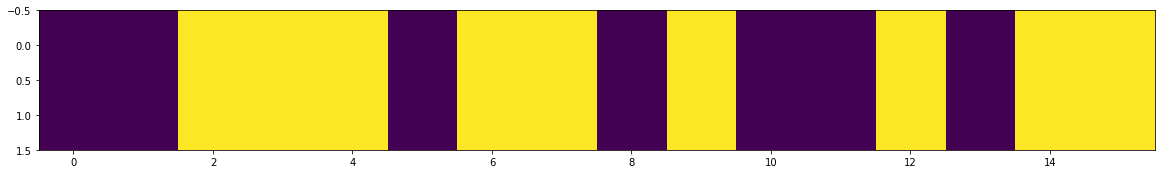

In [1021]:
figsize(20,5)
imshow([res_cpu, res_FPGA])